In [1]:
import os
import json
os.sys.path.append('./audioset/yamnet')
import yamnet as yamnet_model
import params
from datagen_yamnet import DataGenerator, get_files_and_labels

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


# Directory storing the spectrogram inputs for each class
train_dir = './train_set_patches/'

# Path to output model
model_out = './saved_models/model'


#### Get training data files and labels

In [2]:
files_train, labels_train, files_val, labels_val, class_dict = get_files_and_labels(train_dir, typ='npy')
class_dict_rev = {(str(v[0])): k for k, v in class_dict.items()}


#### Load pre-trained YAMNet

In [3]:
yamnet = yamnet_model.yamnet_model()
yamnet.load_weights('./audioset/yamnet/yamnet.h5')

In [4]:
# yamnet.summary()

#### Define custom "top" of YAMNet graph

In [5]:
inpts = tf.keras.layers.Input(shape=(params.PATCH_FRAMES, params.PATCH_BANDS))

x = tf.keras.layers.Dense(64, activation='relu')(yamnet.layers[-3].output)
o = tf.keras.layers.Dropout(0.5)(x)
o = tf.keras.layers.Dense(2, activation='softmax')(o)

model = Model(inputs=yamnet.input, outputs=o)

for layer in model.layers:
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-7)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 64)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 96, 64, 1)         0         
_________________________________________________________________
layer1/conv (Conv2D)         (None, 48, 32, 32)        288       
_________________________________________________________________
layer1/conv/bn (BatchNormali (None, 48, 32, 32)        96        
_________________________________________________________________
layer1/relu (ReLU)           (None, 48, 32, 32)        0         
_________________________________________________________________
layer2/depthwise_conv (Depth (None, 48, 32, 32)        288       
_________________________________________________________________
layer2/depthwise_conv/bn (Ba (None, 48, 32, 32)        96    

#### Initialize data generators

In [6]:
batch_size = 32

train_generator = DataGenerator(files_train,
                                labels_train,
                                batch_size=batch_size)
validation_generator = DataGenerator(files_val,
                                    labels_val,
                                    batch_size=batch_size)

#### Define training hyperparameters

In [7]:
# Save model architecture
model_json = model.to_json()
with open(model_out+'.json', "w") as json_file:
    json_file.write(model_json)
with open(model_out+'_classes.json', 'w') as f:
    json.dump(class_dict, f)
print('Saved model architecture')

# Define training callbacks
checkpoint = ModelCheckpoint(model_out+'.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto')

reducelr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1)

# Compile model
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
    

Saved model architecture


#### Train

In [8]:
try:
    model_history = model.fit(train_generator,
                                steps_per_epoch = len(train_generator),
                                epochs = 20,
                                validation_data = validation_generator,
                                validation_steps = len(validation_generator),
                                verbose = 1,
                                callbacks=[checkpoint, reducelr])
except Exception as e:
    err = e

Epoch 1/20
7/8 [=========================>....] - ETA: 0s - loss: 0.5396
Epoch 00001: val_loss improved from inf to 0.75930, saving model to ./saved_models/model.h5
8/8 [==============================] - 1s 112ms/step - loss: 0.5359 - val_loss: 0.7593 - lr: 1.0000e-04
Epoch 2/20
7/8 [=========================>....] - ETA: 0s - loss: 0.9309
Epoch 00002: val_loss improved from 0.75930 to 0.69859, saving model to ./saved_models/model.h5
8/8 [==============================] - 0s 62ms/step - loss: 0.8403 - val_loss: 0.6986 - lr: 1.0000e-04
Epoch 3/20
7/8 [=========================>....] - ETA: 0s - loss: 0.8849
Epoch 00003: val_loss improved from 0.69859 to 0.68723, saving model to ./saved_models/model.h5
8/8 [==============================] - 0s 60ms/step - loss: 0.8838 - val_loss: 0.6872 - lr: 1.0000e-04
Epoch 4/20
7/8 [=========================>....] - ETA: 0s - loss: 0.6273
Epoch 00004: val_loss did not improve from 0.68723
8/8 [==============================] - 0s 33ms/step - loss: 0.6

#### Plot training history

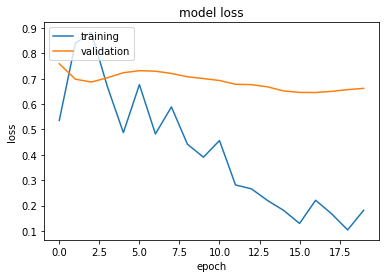

In [10]:
import matplotlib.pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()